# Final competition of Deep Learning 2020 Spring
Traffic environment semi-supervised Learning Contest

## Goals
The objective is to train a model using images captured by six different cameras attached to the same car to generate a top down view of the surrounding area. The performance of the model will be evaluated by (1) the ability of detecting objects (like car, trucks, bicycles, etc.) and (2) the ability to draw the road map layout.

## Data
You will be given two sets of data:

 1. Unlabeled set: just images
 2. Labeled set: images and the labels(bounding box and road map layout)

This notebook will help you understand the dataset.

In [2]:
import os
import random

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = [5, 5]
matplotlib.rcParams['figure.dpi'] = 200

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

from data_helper import UnlabeledDataset, LabeledDataset
from helper import collate_fn, draw_box

dpi = 800
height, width = 800, 800

# What size does the figure need to be in inches to fit the image?
figsize = width / float(dpi), height / float(dpi)

# Create a figure of the right size with one axes that takes up the full figure
fig = plt.figure(figsize=figsize)

In [3]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0);

In [4]:
# All the images are saved in image_folder
# All the labels are saved in the annotation_csv file
image_folder = '../data'
annotation_csv = '../data/annotation.csv'

In [5]:
## scence
!ls ../data

annotation.csv scene_121      scene_26       scene_50       scene_75
scene_0        scene_122      scene_27       scene_51       scene_76
scene_1        scene_123      scene_28       scene_52       scene_77
scene_10       scene_124      scene_29       scene_53       scene_78
scene_100      scene_125      scene_3        scene_54       scene_79
scene_101      scene_126      scene_30       scene_55       scene_8
scene_102      scene_127      scene_31       scene_56       scene_80
scene_103      scene_128      scene_32       scene_57       scene_81
scene_104      scene_129      scene_33       scene_58       scene_82
scene_105      scene_13       scene_34       scene_59       scene_83
scene_106      scene_130      scene_35       scene_6        scene_84
scene_107      scene_131      scene_36       scene_60       scene_85
scene_108      scene_132      scene_37       scene_61       scene_86
scene_109      scene_133      scene_38       scene_62       scene_87
scene_11       scene_14       scene

In [6]:
!ls ../data/scene_0

sample_0   sample_114 sample_18  sample_34  sample_50  sample_67  sample_83
sample_1   sample_115 sample_19  sample_35  sample_51  sample_68  sample_84
sample_10  sample_116 sample_2   sample_36  sample_52  sample_69  sample_85
sample_100 sample_117 sample_20  sample_37  sample_53  sample_7   sample_86
sample_101 sample_118 sample_21  sample_38  sample_54  sample_70  sample_87
sample_102 sample_119 sample_22  sample_39  sample_55  sample_71  sample_88
sample_103 sample_12  sample_23  sample_4   sample_56  sample_72  sample_89
sample_104 sample_120 sample_24  sample_40  sample_57  sample_73  sample_9
sample_105 sample_121 sample_25  sample_41  sample_58  sample_74  sample_90
sample_106 sample_122 sample_26  sample_42  sample_59  sample_75  sample_91
sample_107 sample_123 sample_27  sample_43  sample_6   sample_76  sample_92
sample_108 sample_124 sample_28  sample_44  sample_60  sample_77  sample_93
sample_109 sample_125 sample_29  sample_45  sample_61  sample_78  sample_94
sample_11  sa

In [7]:
!ls ../data/scene_0/sample_0/

CAM_BACK.jpeg        CAM_BACK_RIGHT.jpeg  CAM_FRONT_LEFT.jpeg
CAM_BACK_LEFT.jpeg   CAM_FRONT.jpeg       CAM_FRONT_RIGHT.jpeg


# Dataset

You will get two different datasets:

 1. an unlabeled dataset for pre-training
 2. a labeled dataset for both training and validation
 
## The dataset is organized into three levels: scene, sample and image

 1. A scene is 25 seconds of a car's journey.
 2. A sample is a snapshot of a scene at a given timeframe. Each scene will be divided into 126 samples, so about 0.2 seconds between consecutive samples.
 3. Each sample contains 6 images captured by camera facing different orientation.
    Each camera will capture 70 degree view. To make it simple, you can safely assume that the angle between the cameras is 60 degrees 

106 scenes in the unlabeled dataset and 28 scenes in the labeled dataset

In [8]:
# You shouldn't change the unlabeled_scene_index
# The first 106 scenes are unlabeled
unlabeled_scene_index = np.arange(106)
# The scenes from 106 - 133 are labeled
# You should devide the labeled_scene_index into two subsets (training and validation)
labeled_scene_index = np.arange(106, 134)

# Unlabeled dataset

You get two ways to access the dataset, by sample or by image

## Get Sample

In [9]:
transform = torchvision.transforms.ToTensor()

unlabeled_trainset = UnlabeledDataset(image_folder=image_folder, scene_index=labeled_scene_index, first_dim='sample', transform=transform)
trainloader = torch.utils.data.DataLoader(unlabeled_trainset, batch_size=3, shuffle=True, num_workers=2)

In [10]:
# [batch_size, 6(images per sample), 3, H, W]
sample = iter(trainloader).next()
print(sample.shape)

torch.Size([3, 6, 3, 256, 306])


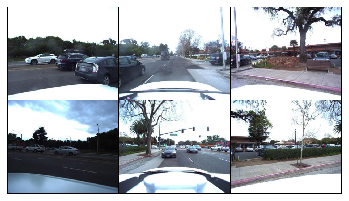

In [11]:
# The 6 images orgenized in the following order:
# CAM_FRONT_LEFT, CAM_FRONT, CAM_FRONT_RIGHT, CAM_BACK_LEFT, CAM_BACK, CAM_BACK_RIGHT
plt.imshow(torchvision.utils.make_grid(sample[2], nrow=3).numpy().transpose(1, 2, 0))
plt.axis('off');

## Get individual image

In [12]:
unlabeled_trainset = UnlabeledDataset(image_folder=image_folder, scene_index=unlabeled_scene_index, first_dim='image', transform=transform)
trainloader = torch.utils.data.DataLoader(unlabeled_trainset, batch_size=2, shuffle=True, num_workers=2)

In [13]:
# [batch_size, 3, H, W]
image, camera_index = iter(trainloader).next()
print(image.shape)

torch.Size([2, 3, 256, 306])


In [14]:
# Camera_index is to tell you which camera is used. The order is
# CAM_FRONT_LEFT, CAM_FRONT, CAM_FRONT_RIGHT, CAM_BACK_LEFT, CAM_BACK, CAM_BACK_RIGHT
print(camera_index[0])

tensor(2)


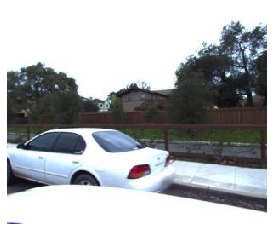

In [15]:
plt.imshow(image[0].numpy().transpose(1, 2, 0))
plt.axis('off');

# Labeled dataset

In [16]:
# The labeled dataset can only be retrieved by sample.
# And all the returned data are tuple of tensors, since bounding boxes may have different size
# You can choose whether the loader returns the extra_info. It is optional. You don't have to use it.
labeled_trainset = LabeledDataset(image_folder=image_folder,
                                  annotation_file=annotation_csv,
                                  scene_index=labeled_scene_index,
                                  transform=transform,
                                  extra_info=True
                                 )
trainloader = torch.utils.data.DataLoader(labeled_trainset, batch_size=2, shuffle=True, num_workers=2, collate_fn=collate_fn)

In [17]:
sample, target, road_image, extra = iter(trainloader).next()
print(torch.stack(sample).shape)

torch.Size([2, 6, 3, 256, 306])


There are two kind of labels

 1. The bounding box of surrounding objects
 2. The binary road_image

## Bounding box

In [18]:
# The shape of bounding box is [batch_size, N (the number of object), 2, 4]
print(target[0]['bounding_box'].shape)

torch.Size([16, 2, 4])


In [19]:
# All bounding box are retangles
# Each bounding box is organized with four corners of the box
# All the values are in meter and bounded by 40 meters, and the origin is the center of ego car
# the order of the four courners are front left, front right, back left and back right
print(target[0]['bounding_box'][0])

tensor([[29.1092, 29.1643, 20.9320, 20.9871],
        [-2.1322, -4.8175, -2.3005, -4.9858]], dtype=torch.float64)


In [20]:
# Each bounding box has a category
# 'other_vehicle': 0,
# 'bicycle': 1,
# 'car': 2,
# 'pedestrian': 3,
# 'truck': 4,
# 'bus': 5,
# 'motorcycle': 6,
# 'emergency_vehicle': 7,
# 'animal': 8
print(target[0]['category'])

tensor([0, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0])


## Road Map Layout


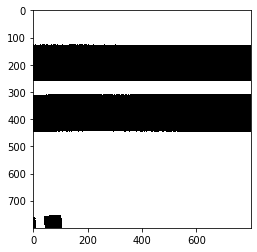

In [21]:
# The road map layout is encoded into a binary array of size [800, 800] per sample 
# Each pixel is 0.1 meter in physiscal space, so 800 * 800 is 80m * 80m centered at the ego car
# The ego car is located in the center of the map (400, 400) and it is always facing the left

fig, ax = plt.subplots()

ax.imshow(road_image[0], cmap='binary');

In [22]:
print(road_image[0])

tensor([[False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        ...,
        [ True,  True,  True,  ..., False, False, False],
        [ True,  True,  True,  ..., False, False, False],
        [ True,  True,  True,  ..., False, False, False]])


## Extra Info

There is some extra information you can use in your model, but it is optional.

In [23]:
# Action
# Action is the label that what the object is doing

# 'object_action_parked': 0,
# 'object_action_driving_straight_forward': 1,
# 'object_action_walking': 2,
# 'object_action_running': 3,
# 'object_action_lane_change_right': 4,
# 'object_action_stopped': 5,
# 'object_action_left_turn': 6,
# 'object_action_right_turn': 7,
# 'object_action_sitting': 8,
# 'object_action_standing': 9,
# 'object_action_gliding_on_wheels': 10,
# 'object_action_abnormal_or_traffic_violation': 11,
# 'object_action_lane_change_left': 12,
# 'object_action_other_motion': 13,
# 'object_action_reversing': 14,
# 'object_action_u_turn': 15,
# 'object_action_loss_of_control': 16

In [24]:
print(extra[0]['action'])

tensor([0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0])


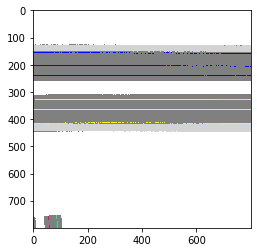

In [25]:
# Ego Image
# A more detailed ego image
fig, ax = plt.subplots()

ax.imshow(extra[0]['ego_image'].numpy().transpose(1, 2, 0));

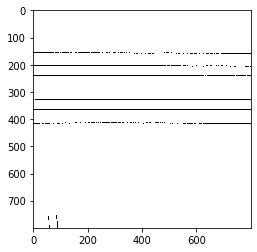

In [26]:
# Lane Image
# Binary lane image
fig, ax = plt.subplots()

ax.imshow(extra[0]['lane_image'], cmap='binary');

# Visualize the bounding box

In [58]:
import io
import matplotlib
from PIL import Image
import matplotlib.pyplot as plt
#matplotlib.rcParams['figure.figsize'] = [5, 5]
matplotlib.rcParams['figure.dpi'] = 800

def draw_filled_box(ax, corners, color):
    point_squence = torch.stack([corners[:, 0], corners[:, 1], corners[:, 3], corners[:, 2], corners[:, 0]])
    
    # the corners are in meter and time 10 will convert them in pixels
    # Add 400, since the center of the image is at pixel (400, 400)
    # The negative sign is because the y axis is reversed for matplotlib
    ax.fill(point_squence.T[0] * 10 + 400, -point_squence.T[1] * 10 + 400, color=color)
    
def generate_image(target):
    # The center of image is 400 * 400
    fig, ax = plt.subplots()
    ax.axis('off')
    ax.set_xlim(0,800)
    ax.set_ylim(0,800)
    for t in target['bounding_box']:
        draw_filled_box(ax, t, color='black') 
    plt.close(fig)
    # convert to PIL Image object
    buffer = io.BytesIO()
    fig.savefig(buffer, format='png', dpi=200, bbox_inches='tight')
    buffer.seek(0)
    im = Image.open(buffer).convert('L').transpose(Image.FLIP_TOP_BOTTOM)
    img_arr = np.asarray(im)
    buffer.close()
    return img_arr

def get_target_array(targets):
    n = len(targets)
    array_targets = []
    for idx, target in enumerate(targets):
        array_targets.append(generate_image(target))
    return array_targets

In [59]:
arr = get_target_array(target)

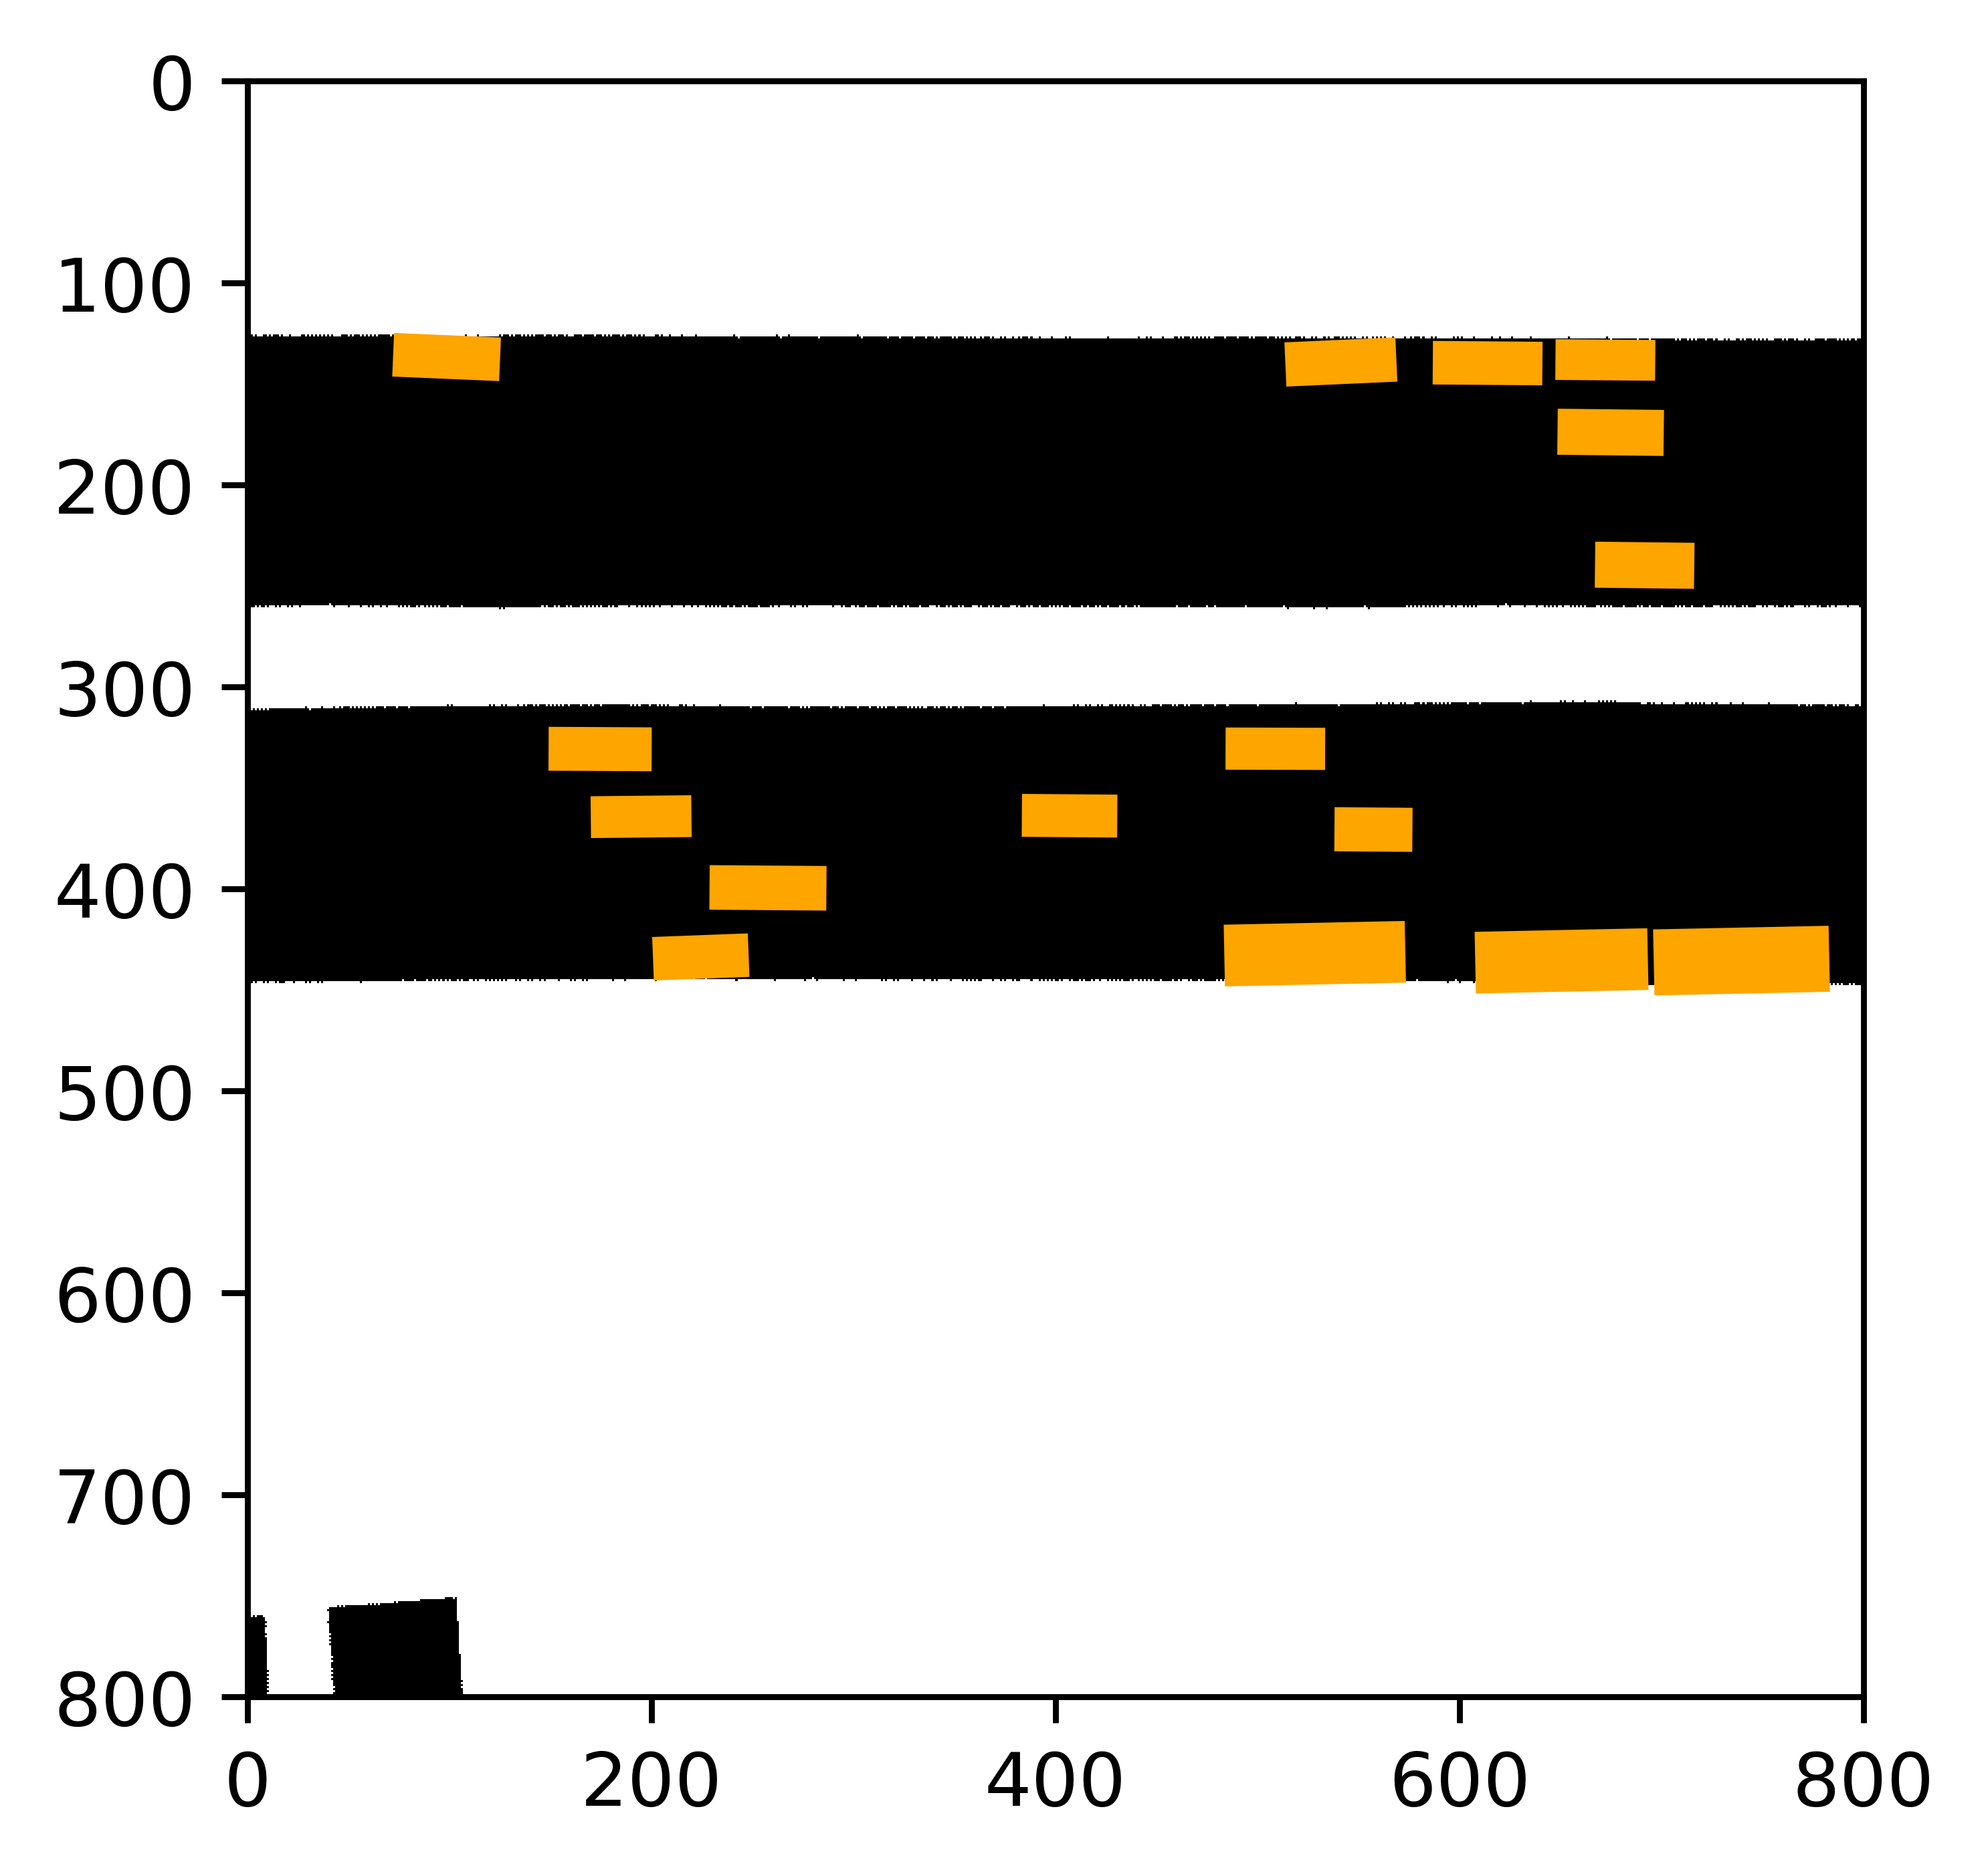

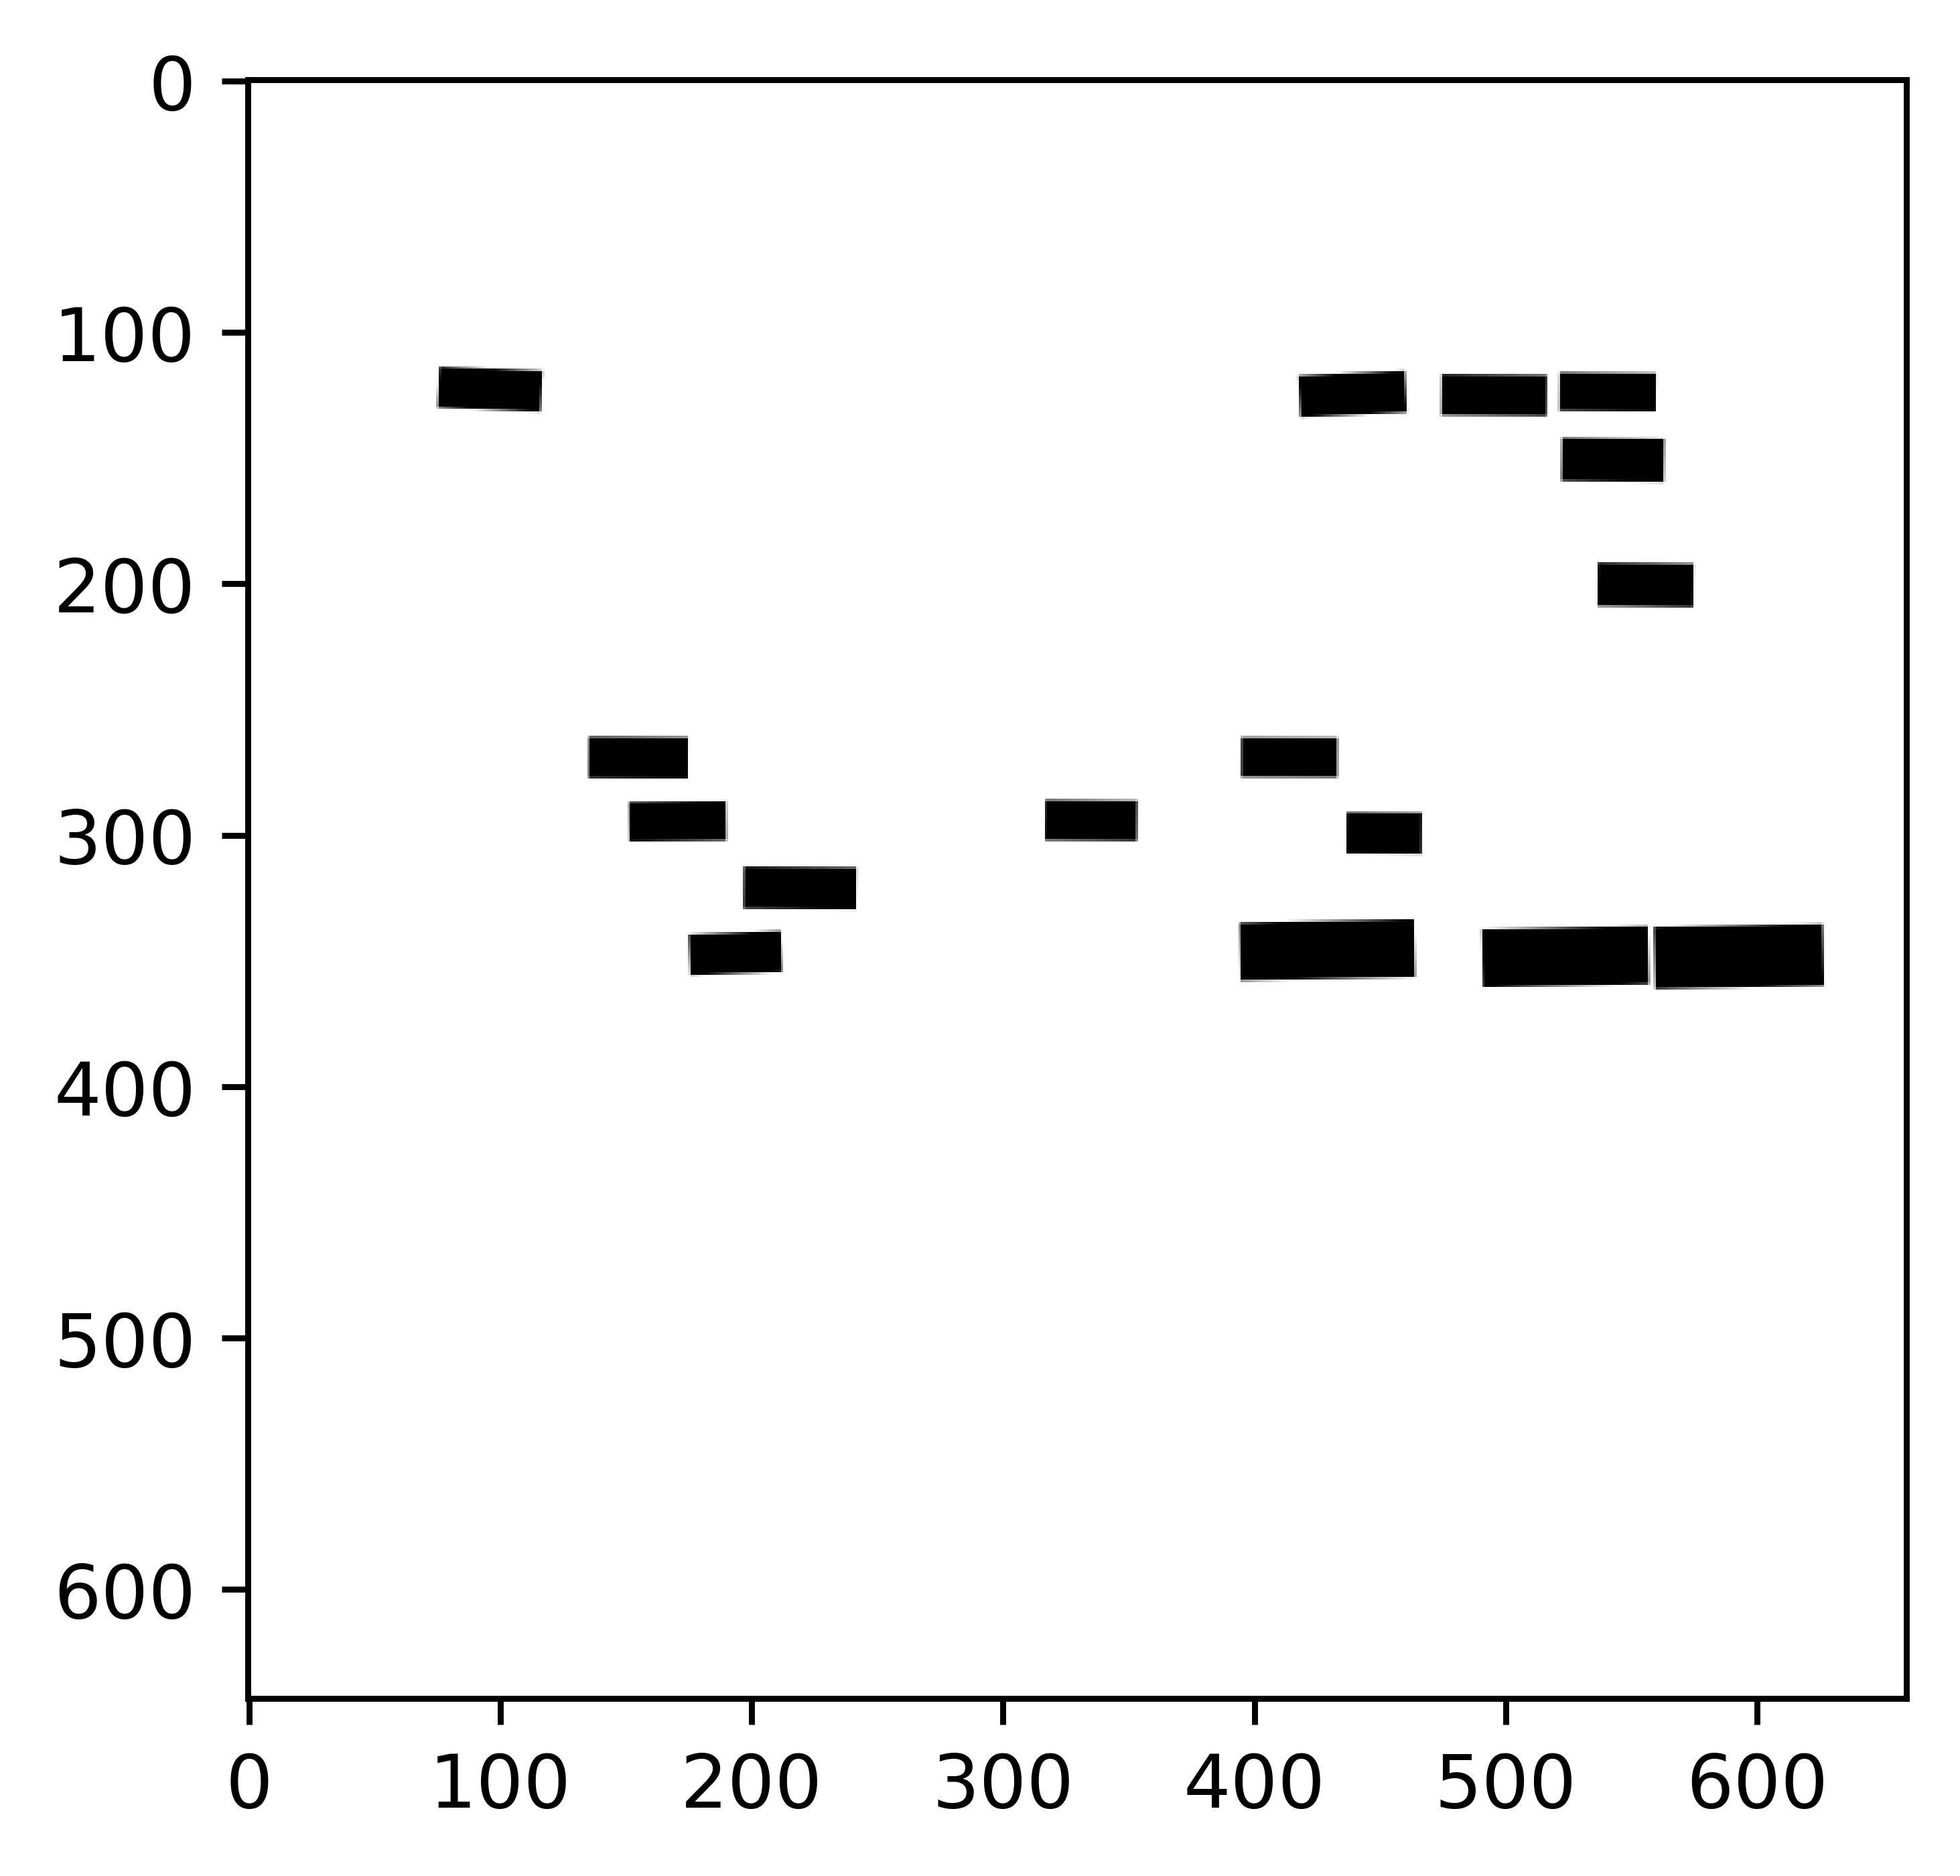

In [60]:
fig, ax = plt.subplots()
ax.axis('on')
ax.set_xlim(0,800)
ax.set_ylim(800,0)
matplotlib.rcParams['figure.figsize'] = [4, 4]
for t in target[0]['bounding_box']:
    draw_filled_box(ax,t, color='orange')
ax.imshow(road_image[0], cmap='binary');
plt.show()
plt.imshow(arr[0], cmap='gray')

In [46]:
arr[0].shape

(800, 800)

In [145]:
np.unique(arr[0]/255, return_counts=True)

(array([1.]), array([640000]))

In [146]:
arr[0]

array([[255., 255., 255., ..., 255., 255., 255.],
       [255., 255., 255., ..., 255., 255., 255.],
       [255., 255., 255., ..., 255., 255., 255.],
       ...,
       [255., 255., 255., ..., 255., 255., 255.],
       [255., 255., 255., ..., 255., 255., 255.],
       [255., 255., 255., ..., 255., 255., 255.]])

In [ ]:
reconstruct_img = Image.fromarray(img_arr)
reconstruct_img.show()

# Evaluation
During the whole competition, you have three submission deadlines. The dates will be announced on Piazza. You will have to fill up the template 'data_loader.py' for evaluation. (see the comment inside data_loader.py' for more information)

There will be two leaderboards for the competition:
The leaderboard for binary road map.
We will evaluate your model's performance by using the average threat score (TS) across the test set:
$$\text{TS} = \frac{\text{TP}}{\text{TP} + \text{FP} + \text{FN}}$$
The leaderboard for object detection:
We will evaluate your model's performance for object detection by using the average mean threat score at different intersection over union (IoU) thresholds.
There will be five different thresholds (0.5, 0.6, 0.7, 0.8, 0.9). For each thresholds, we will calculate the threat score. The final score will be a weighted average of all the threat scores:
$$\text{Final Score} = \sum_t \frac{1}{t} \cdot \frac{\text{TP}(t)}{\text{TP}(t) + \text{FP}(t) + \text{FN}(t)}$$
